In [94]:
#CONSTANTS
import matplotlib.pyplot as plt
import numpy as np
from mpmath import ellipk

J = 1
kb = 1
T = 2.2
threshold = 200000
dimension = 20
iterations = (dimension**2)*2000
n = iterations - threshold
kmax = int(n/10)

In [95]:
#INITIAL SYSTEM
def setup(dimension):
    matrix = []
    for i in range(dimension):
        line_i = []
        for j in range(dimension):
            line_i.append(int(np.random.choice([-1,1])))
        matrix.append(line_i)
    return matrix

class system:
    def __init__(self,matrix):
        self.matrix = matrix
        self.dimension = len(self.matrix)
    def change(self,i,j):
        self.matrix[i][j] = -self.matrix[i][j]
    
    def neighbors(self,i,j):
        dim = self.dimension
        return [(i+1)%dim,(i-1)%dim,(j+1)%dim,(j-1)%dim]


In [ ]:
#METHODS OF ENERGY AND MAGNETIZATION COMPUTATIONS AND TIME EVOLUTION

class Ising_0:
    def __init__(self,system):
        self.E = self.energy(system)
        self.mag = self.magnetization(system)
    
    def energy(self,system):
        H = 0
        dim = system.dimension
        for i in range(dim):
            for j in range(dim):
                H-= J*system.matrix[i][j]*system.matrix[(i+1)%dim][j] 
                H-= J*system.matrix[i][j]*system.matrix[i][(j+1)%dim]
        return H
    
    def magnetization(self,system):
        return sum(sum(k) for k in system.matrix)
    
class montecarlo_0:
    def __init__(self,system,model):
        self.system = system
        self.dimension = system.dimension
        self.model = model
        self.E = model.energy(system)
        self.mag = model.magnetization(system)

    def metropolis(self,dE,T):
        if dE < 0:
            return True
        elif np.random.random() < np.e**(-dE/(kb*T)):
            return True
        else:
            return False
        
    def evolution(self,T):
        dim = self.dimension
        i = np.random.randint(0,dim)
        j = np.random.randint(0,dim)
        spins = self.system.matrix
        neighbors = self.system.neighbors(i,j)

        dE = 2*J*spins[i][j] * (self.system.matrix[neighbors[0]][j] + self.system.matrix[neighbors[1]][j]+self.system.matrix[i][neighbors[2]] + self.system.matrix[i][neighbors[3]]) 
        

        if self.metropolis(dE,T):
            self.system.change(i,j)
            self.E += dE
            self.mag += 2*self.system.matrix[i][j]


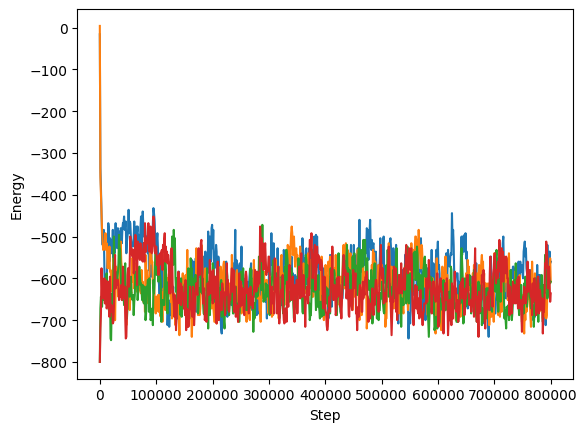

In [99]:
#THERMALIZATION TIME

#Generate two hot starts and two cold starts
systems = []
systems.append(system(setup(dimension)))
systems.append(system(setup(dimension)))
systems.append(system([[-1 for i in range(dimension)] for i in range(dimension)]))
systems.append(system([[1 for i in range(dimension)] for i in range(dimension)]))



for syst in systems:

    model_1 = Ising_0(syst)
    simulation = montecarlo_0(syst,model_1)
    energies = []
    magnetizations = []

    for i in range(iterations):
        simulation.evolution(T)
        if i%1000 == 0:
            energies.append(simulation.E)
            magnetizations.append(simulation.mag)
    plt.plot(np.linspace(0,iterations,int(iterations/1000)),energies)
plt.xlabel("Step")
plt.ylabel("Energy")
plt.show()



In [19]:
#Mean, variance and covariance
def average(list):
    return sum(list)/len(list)

def var(list):
    av = average(list)
    var=0
    for i in range(len(list)):
        var += (list[i] - av)**2
    return var/(len(list)-1)

def autocov(list,av_list,k):
    ac = 0
    leng = len(list)
    for i in range(leng-k):
        ac += (list[i] - av_list)*(list[i+k] - av_list)
    return ac/(leng-k)



In [115]:
#CONVERGENCE
systems = []
systems.append(system(setup(dimension)))
systems.append(system(setup(dimension)))
systems.append(system([[-1 for i in range(dimension)] for i in range(dimension)]))
systems.append(system([[1 for i in range(dimension)] for i in range(dimension)]))



averages_E = []
averages_mag = []
var_E = []
var_mag = []

for syst in systems:
    
    model_1 = Ising(syst)
    simulation = montecarlo(syst,model_1)
    energies = []
    magnetizations = []

    for i in range(iterations):
        simulation.evolution(T)
        if i > threshold:
            energies.append(simulation.E)
            magnetizations.append(abs(simulation.mag))
    
    #Compute the variance and mean of each simulation
    var_E.append(var(energies))
    var_mag.append(var(magnetizations))
    
    averages_E.append(average(energies))
    averages_mag.append(average(magnetizations))

#Mean variance on each chain
W_E = average(var_E)
W_mag = average(var_mag)

#Variance between chain means
B_E = n * var(averages_E)
B_mag = n * var(averages_mag)


#Gelman-Rubin statistic
R_E = np.sqrt((B_E/n + W_E*(n-1)/n)/W_E)
R_mag = np.sqrt((B_mag/n + W_mag*(n-1)/n)/W_mag)


print(R_E)
print(R_mag)



1.041566536944484
1.0859480613567771


In [80]:
#Simulation

syst = system(setup(dimension))
model_1 = Ising_0(syst)
simulation = montecarlo_0(syst,model_1)

energies = []
magnetizations = []

for i in range(iterations):
    simulation.evolution(T)

    if i > threshold and i%1600 == 0:
        energies.append(simulation.E)
        magnetizations.append(simulation.mag)


In [ ]:
#Madras-Sokal with FFT

def autocorr_fft(x):
    x = np.asarray(x)
    x = x - np.mean(x)
    N = len(x)

    f = np.fft.fft(x, n=2*N)
    acf = np.fft.ifft(f * np.conjugate(f))[:N].real
    return acf/acf[0]

def tau(rho, c=6):
    W = 1
    tau = 0.5 + np.sum(rho[1:W])
    W_new = int(c * tau)

    while W_new > W and W_new < len(rho):
        W = W_new
        tau = 0.5 + np.sum(rho[1:W])
        W_new = int(c * tau)

    return tau, W

rho_E = autocorr_fft(energies)
tau_E, W_E = tau(rho_E)

rho_M = autocorr_fft(magnetizations)
tau_M, W_M = tau(rho_M)

print(tau_E)
print(tau_M)

29.06724475936406
35.177567330048795
